# Transfer Learning with TensorFlow Part 2: Fine-tuning

In this notebook we will go for fine tuning. 

## Model 2: Feature extraction transfer learning with 10% of data and data augmentation

Alright, we've tested 1% of the training data with data augmentation, how about we try 10% of the data with data augmentation?

But wait...

> 🤔 **Question:** How do you know what experiments to run?

Great question.

The truth here is you often won't. Machine learning is still a very experimental practice. It's only after trying a fair few things that you'll start to develop an intuition of what to try.

My advice is to follow your curiosity as tenaciously as possible. If you feel like you want to try something, write the code for it and run it. See how it goes. The worst thing that'll happen is you'll figure out what doesn't work, the most valuable kind of knowledge.

From a practical standpoint, as we've talked about before, you'll want to reduce the amount of time between your initial experiments as much as possible. In other words, run a plethora of smaller experiments, using less data and less training iterations before you find something promising and then scale it up.

In the theme of scale, let's scale our 1% training data augmentation experiment up to 10% training data augmentation. That sentence doesn't really make sense but you get what I mean.

We're going to run through the exact same steps as the previous model, the only difference being using 10% of the training data instead of 1%.

## Creating helper functions

In previous notebook we created a lot of helper functions. This is tedious. 

So it's a good idea to put functions we'll want to use again in a script we can download and import into our notebooks

We've done this for some of the functions we've used previously here: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py



In [1]:
# !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


--2024-07-10 22:05:02--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8001::154, 2606:50c0:8002::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: 'helper_functions.py.1'

     0K ..........                                            100% 5.68M=0.002s

2024-07-10 22:05:03 (5.68 MB/s) - 'helper_functions.py.1' saved [10246/10246]



In [1]:
# Import helper functins we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir


## Getting some data

This time we're going to see how we can use pretrained models within tf.keras.applications and apply them to our own problem.


In [3]:
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# unzip_data("10_food_classes_10_percent.zip")

--2024-07-10 22:05:22--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 2404:6800:4009:80f::201b, 2404:6800:4009:813::201b, 2404:6800:4009:81a::201b, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2404:6800:4009:80f::201b|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: '10_food_classes_10_percent.zip.1'

     0K .......... .......... .......... .......... ..........  0%  119K 22m58s
    50K .......... .......... .......... .......... ..........  0%  171K 19m30s
   100K .......... .......... .......... .......... ..........  0%  454K 15m1s
   150K .......... .......... .......... .......... ..........  0%  443K 12m48s
   200K .......... .......... .......... .......... ..........  0%  520K 11m17s
   250K .......... .......... .......... .......... ..........  0%  687K 10m4s
   300K .......... ....

In [2]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [3]:
# Create training and test directories paths
train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [4]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
# Note: the test data is the same as the previous experiment, we could
# skip creating this, but we'll leave this here to practice.
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [5]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [6]:
# Check out class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [7]:
# See an example of a bath of data

for images, labels in train_data_10_percent.take(1):
    print(images, labels)

tf.Tensor(
[[[[159.7143    128.7143     74.07143  ]
   [152.        120.         59.28571  ]
   [152.9949    119.78062    48.137753 ]
   ...
   [123.        100.         86.       ]
   [129.0714    103.07139    90.07139  ]
   [123.086685   97.086685   84.086685 ]]

  [[169.38264   138.05103    85.       ]
   [159.2143    129.14285    67.5      ]
   [148.72958   118.102036   47.530613 ]
   ...
   [124.71431   101.71431    85.71431  ]
   [126.862206  103.862206   87.862206 ]
   [125.474525   99.474525   84.474525 ]]

  [[167.64285   135.99489    86.       ]
   [168.14285   137.12755    80.78571  ]
   [157.52551   126.09694    59.09694  ]
   ...
   [132.16835   109.42855    90.78569  ]
   [126.729546  103.943825   85.30097  ]
   [123.21947   100.433754   81.79089  ]]

  ...

  [[190.42853   181.78574   159.42853  ]
   [191.41322   182.77043   161.9847   ]
   [191.42853   182.78574   162.       ]
   ...
   [194.95409   182.95409   166.95409  ]
   [191.2704    183.05614   164.48466  ]
   [1

base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

## Model 0: Building a transfer learning model using Keras Functional API

The sequential API is straight forward, it runs over layers in sequential order.

But the functional API gives us more flexibility with our models.

In [10]:
# Create a functional model with data augmentation
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers.experimental import preprocessing # OLD

# NEW: Newer versions of TensorFlow (2.10+) can use the tensorflow.keras.layers API directly for data augmentation
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet
], name ="data_augmentation")

# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model
# base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Create input and output layers
inputs = layers.Input(shape=input_shape, name="input_layer") # create input layer
x = data_augmentation(inputs) # augment our training images
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # use Adam optimizer with base learning rate
              metrics=["accuracy"])

In [11]:
def create_base_model(input_shape: tuple[int, int, int] = (224, 224, 3),
                      output_shape: int = 10,
                      learning_rate: float = 0.001,
                      training: bool = False) -> tf.keras.Model:
    """
    Create a model based on EfficientNetV2B0 with built-in data augmentation.

    Parameters:
    - input_shape (tuple): Expected shape of input images. Default is (224, 224, 3).
    - output_shape (int): Number of classes for the output layer. Default is 10.
    - learning_rate (float): Learning rate for the Adam optimizer. Default is 0.001.
    - training (bool): Whether the base model is trainable. Default is False.

    Returns:
    - tf.keras.Model: The compiled model with specified input and output settings.
    """

    # Create base model
    base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
    base_model.trainable = training

    # Setup model input and outputs with data augmentation built-in
    inputs = layers.Input(shape=input_shape, name="input_layer")
    x = data_augmentation(inputs)
    x = base_model(x, training=False)  # pass augmented images to base model but keep it in inference mode
    x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
    outputs = layers.Dense(units=output_shape, activation="softmax", name="output_layer")(x)
    model = tf.keras.Model(inputs, outputs)

    # Compile model
    model.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy"])

    return model

# Create an instance of model_2 with our new function
model_2 = create_base_model()

In [12]:
# Setup checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt" # note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=True, # save only the best model weights instead of a model every epoch
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

In [13]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)), # do less steps per validation (quicker)
                                          callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"),
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20240712-215445
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9525 - accuracy: 0.3693
Epoch 1: val_loss improved from inf to 1.38045, saving model to ten_percent_model_checkpoints_weights\checkpoint.ckpt
24/24 [==============================] - 57s 1s/step - loss: 1.9525 - accuracy: 0.3693 - val_loss: 1.3804 - val_accuracy: 0.6924
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3909 - accuracy: 0.6360
Epoch 2: val_loss improved from 1.38045 to 1.01101, saving model to ten_percent_model_checkpoints_weights\checkpoint.ckpt
24/24 [==============================] - 27s 1s/step - loss: 1.3909 - accuracy: 0.6360 - val_loss: 1.0110 - val_accuracy: 0.7780
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0813 - accuracy: 0.7173
Epoch 3: val_loss improved from 1.01101 to 0.82283, saving model to ten_percent_model_checkpoints_weights\checkpoint.ckpt
24/24 [=======

In [14]:
# Evaluate on the test data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 10s 123ms/step - loss: 0.6635 - accuracy: 0.8300


[0.6634939312934875, 0.8299999833106995]

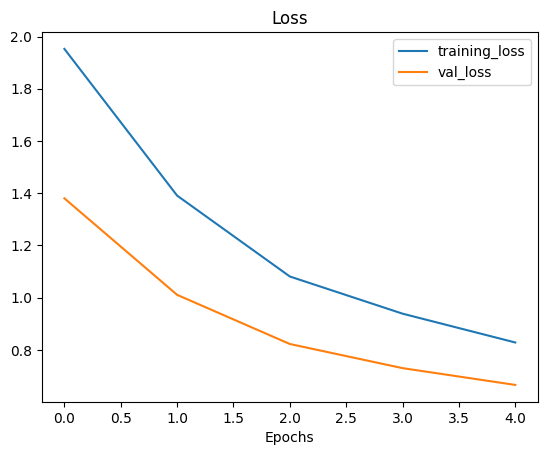

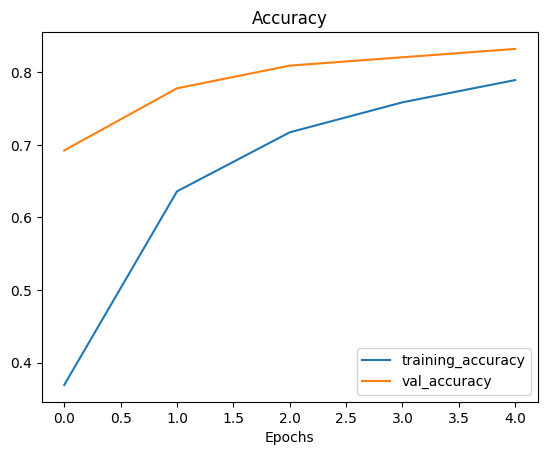

In [15]:
# Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

In [16]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 9s 105ms/step - loss: 0.6635 - accuracy: 0.8300


In [17]:
# If the results from our native model and the loaded weights are the same, this should output True
results_10_percent_data_aug == loaded_weights_model_results

False

In [18]:
import numpy as np
# Check to see if loaded model results are very close to native model results (should output True)
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [19]:
# Check the difference between the two results (small values)
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[1.1920929e-07 0.0000000e+00]


## Model 3: Fine-tuning an existing model on 10% of the data

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/05-fine-tuning-an-efficientnet-model.png)
*High-level example of fine-tuning an EfficientNet model. Bottom layers (layers closer to the input data) stay frozen where as top layers (layers closer to the output data) are updated during training.*

So far our saved model has been trained using feature extraction transfer learning for 5 epochs on 10% of the training data and data augmentation.

This means all of the layers in the base model (`EfficientNetV2B0`) were frozen during training.

For our next experiment we're going to switch to fine-tuning transfer learning. This means we'll be using the same base model except we'll be unfreezing some of its layers (ones closest to the top) and running the model for a few more epochs.

The idea with fine-tuning is to start customizing the pre-trained model more to our own data.

> 🔑 **Note:** Fine-tuning usually works best *after* training a feature extraction model for a few epochs and with large amounts of data. For more on this, check out [Keras' guide on Transfer learning & fine-tuning](https://keras.io/guides/transfer_learning/).

We've verified our loaded model's performance, let's check out its layers.

In [20]:
# Layers in loaded model
model_2.layers

In [21]:
for layer_number, layer in enumerate(model_2.layers):
    print(f"Layer number: {layer_number} | Layer name: {layer.name} | Layer type: {layer} | Trainable? {layer.trainable}")

Layer number: 0 | Layer name: input_layer | Layer type: <keras.engine.input_layer.InputLayer object at 0x0000014C83BEA1A0> | Trainable? True
Layer number: 1 | Layer name: data_augmentation | Layer type: <keras.engine.sequential.Sequential object at 0x0000014BC78AE5F0> | Trainable? True
Layer number: 2 | Layer name: efficientnetv2-b0 | Layer type: <keras.engine.functional.Functional object at 0x0000014BE9210FA0> | Trainable? False
Layer number: 3 | Layer name: global_average_pooling_layer | Layer type: <keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x0000014C83AD2530> | Trainable? True
Layer number: 4 | Layer name: output_layer | Layer type: <keras.layers.core.dense.Dense object at 0x0000014B8108FEB0> | Trainable? True


In [22]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                           

In [23]:
# Access the base_model layers of model_2
model_2_base_model = model_2.layers[2]
model_2_base_model.name

'efficientnetv2-b0'

In [24]:
# How many layers are trainable in our model_2_base_model
print(len(model_2_base_model.trainable_variables))

0


In [1]:
# Check which layers are tunable
for layer_number, layer in enumerate(model_2_base_model.layers):
    print(layer_number, layer.name, layer.trainable)

NameError: name 'model_2_base_model' is not defined

In [26]:
# Make all layers in model_2_base_model trainable
model_2_base_model.trainable = True

# Freeze all layers except for the last 10
for layer in model_2_base_model.layers[:-10]:
    layer.trainable = False

# Recompile the whole model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [27]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(model_2_base_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [28]:
print(len(model_2.trainable_variables))

12


In [29]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               initial_epoch=history_10_percent_data_aug.epoch[-1], # Start from previous last epoch
                                               validation_steps=int(0.25 * len(test_data)),
                                               callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")])    # Name experiment (choose name appropriately)


Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20240712-222544
Epoch 5/10
24/24 [==============================] - 45s 1s/step - loss: 0.6711 - accuracy: 0.8107 - val_loss: 0.5116 - val_accuracy: 0.8503
Epoch 6/10
24/24 [==============================] - 24s 1s/step - loss: 0.5818 - accuracy: 0.8120 - val_loss: 0.5305 - val_accuracy: 0.8191
Epoch 7/10
24/24 [==============================] - 28s 1s/step - loss: 0.5275 - accuracy: 0.8320 - val_loss: 0.4741 - val_accuracy: 0.8388
Epoch 8/10
24/24 [==============================] - 35s 1s/step - loss: 0.4838 - accuracy: 0.8507 - val_loss: 0.4674 - val_accuracy: 0.8438
Epoch 9/10
24/24 [==============================] - 23s 949ms/step - loss: 0.4704 - accuracy: 0.8560 - val_loss: 0.4799 - val_accuracy: 0.8388
Epoch 10/10
24/24 [==============================] - 23s 940ms/step - loss: 0.4416 - accuracy: 0.8560 - val_loss: 0.4879 - val_accuracy: 0.8438


In [30]:
# Evaluate the model of the test data
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 10s 113ms/step - loss: 0.4475 - accuracy: 0.8524


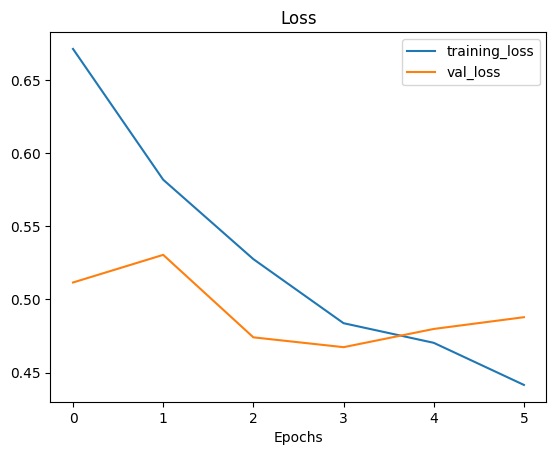

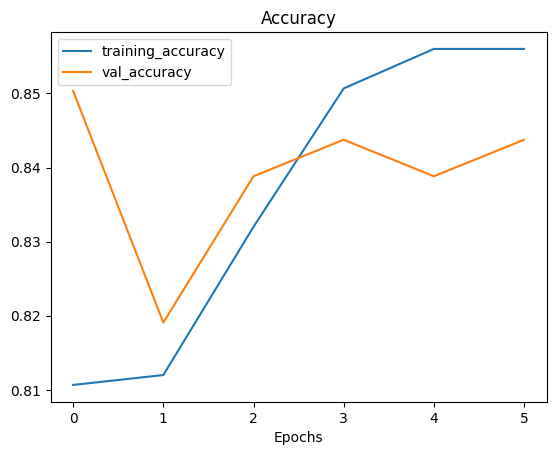

In [31]:
plot_loss_curves(history_fine_10_percent_data_aug)

The 'plot_loss_curves' function works great with models which have only been fit once. However, we want something to compare one series of running **fit()** with another (eg. before and after fine-tuning)

In [36]:
import matplotlib.pyplot as plt

def compare_histories(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plot for accuracy
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Make plot for loss

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

5
11
[0.36933332681655884, 0.6359999775886536, 0.7173333168029785, 0.7586666941642761, 0.7893333435058594, 0.8106666803359985, 0.8119999766349792, 0.8320000171661377, 0.8506666421890259, 0.8560000061988831, 0.8560000061988831]


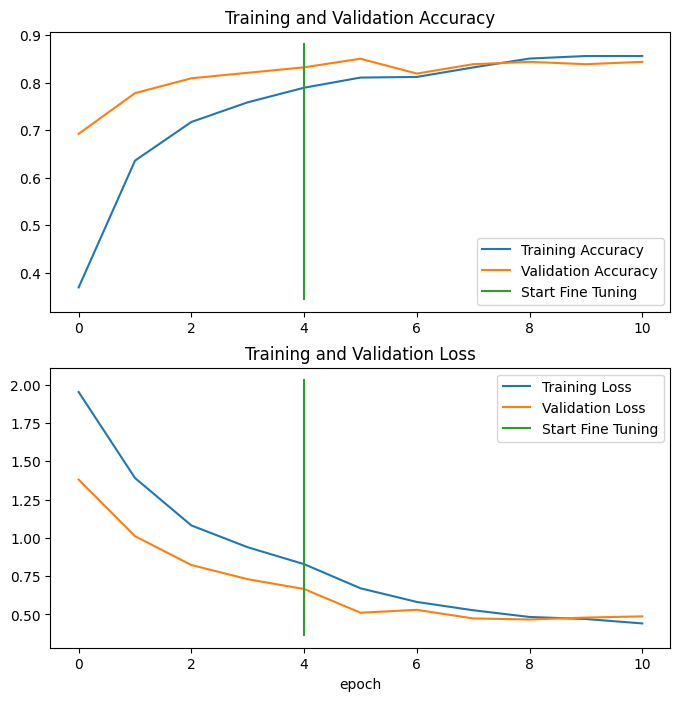

In [37]:
compare_histories(history_10_percent_data_aug,
                  history_fine_10_percent_data_aug,
                  initial_epochs=5)

## Model 4: Fine-tuning and existing model on all of the data

In [38]:
# Download and unzip 10 classes of Food101 data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2024-07-12 23:22:15--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 2404:6800:4009:809::201b, 2404:6800:4009:80d::201b, 2404:6800:4009:81a::201b, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2404:6800:4009:809::201b|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: '10_food_classes_all_data.zip'

     0K .......... .......... .......... .......... ..........  0%  116K 72m34s
    50K .......... .......... .......... .......... ..........  0%  165K 61m57s
   100K .......... .......... .......... .......... ..........  0%  455K 47m29s
   150K .......... .......... .......... .......... ..........  0%  431K 40m31s
   200K .......... .......... .......... .......... ..........  0%  508K 35m44s
   250K .......... .......... .......... .......... ..........  0%  673K 31m52s
   300K .......... ........

In [39]:
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [40]:
# How many images?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data\test'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\steak'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\sushi'.
There are 

In [41]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)


Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset we've loaded in is the same as what we've been using for previous experiments (all experiments have used the same test dataset)

In [42]:
# Evaluate model 2 (this is the fine-tuned on 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 12s 130ms/step - loss: 0.4475 - accuracy: 0.8524


[0.44751089811325073, 0.852400004863739]

In [43]:
results_fine_tune_10_percent

[0.44751089811325073, 0.852400004863739]

To train a fine-tuning model (model_4) we need to revert model_2 back to its feature extraction weights

In [44]:
# Load weights from checkpoint, that way we can fine-tune from
# the same stage the 10 percent data model was fine-tuned from

model_2.load_weights(checkpoint_path)

In [45]:
# Lets evaluate model_2
model_2.evaluate(test_data)

79/79 [==============================] - 10s 118ms/step - loss: 0.6635 - accuracy: 0.8300


[0.6634939312934875, 0.8299999833106995]

In [46]:
# Check to see if our model_2 has been reverted back to feature extraction results
results_10_percent_data_aug

[0.6634939312934875, 0.8299999833106995]

In the previous steps all we've done is:

1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data with data augmentation (model_2) and we saved the model's weights using **ModelCheckpoint** callback
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen (model_3)
3. Saved the results and training logs each time
4. Reloaded the model from step 1 to do the same steps as step 2 except this time we're going to use all of the data (model_4)

In [47]:
# Check which layers are tunable in the whole model
for layer_number, layer in enumerate(model_2.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetv2-b0 True
3 global_average_pooling_layer True
4 output_layer True


In [49]:
# Let's drill into our base_model (efficientnetb0) and see what layers are trainable
for layer_number, layer in enumerate(model_2.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [50]:
# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])



In [51]:
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                  experiment_name="full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20240713-001027
Epoch 5/10
235/235 [==============================] - 233s 897ms/step - loss: 0.7152 - accuracy: 0.7711 - val_loss: 0.4099 - val_accuracy: 0.8586
Epoch 6/10
235/235 [==============================] - 225s 958ms/step - loss: 0.5958 - accuracy: 0.8069 - val_loss: 0.3605 - val_accuracy: 0.8717
Epoch 7/10
235/235 [==============================] - 214s 909ms/step - loss: 0.5507 - accuracy: 0.8212 - val_loss: 0.3430 - val_accuracy: 0.8914
Epoch 8/10
235/235 [==============================] - 198s 841ms/step - loss: 0.4996 - accuracy: 0.8367 - val_loss: 0.2935 - val_accuracy: 0.9079
Epoch 9/10
235/235 [==============================] - 202s 858ms/step - loss: 0.4748 - accuracy: 0.8485 - val_loss: 0.2861 - val_accuracy: 0.9030
Epoch 10/10
235/235 [==============================] - 177s 754ms/step - loss: 0.4556 - accuracy: 0.8500 - val_loss: 0.2652 - val_accuracy: 0.9062


In [52]:
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 10s 116ms/step - loss: 0.2719 - accuracy: 0.9096


[0.2719495892524719, 0.909600019454956]

5
11
[0.36933332681655884, 0.6359999775886536, 0.7173333168029785, 0.7586666941642761, 0.7893333435058594, 0.7710666656494141, 0.8069333434104919, 0.8212000131607056, 0.8366666436195374, 0.8485333323478699, 0.8500000238418579]


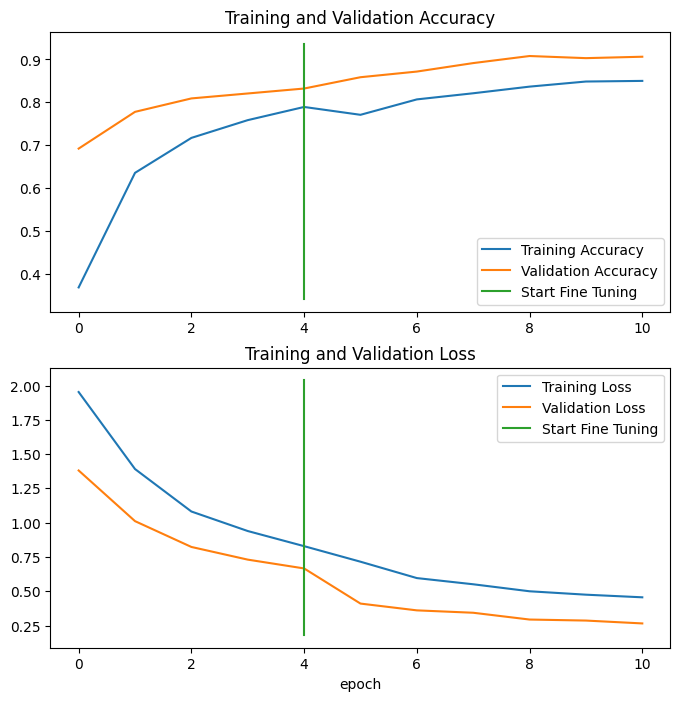

In [53]:
compare_histories(original_history=history_10_percent_data_aug,
                  new_history=history_fine_10_classes_full,
                  initial_epochs=5)

In [55]:
!tensorboard dev upload --logdir ./transfer_learning \
  --name "Transfer learning experiments" \
  --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning" \
  --one_shot # exits the uploader when upload has finished

usage: tensorboard [-h] [--helpfull] {serve,dev} ...
tensorboard: error: unrecognized arguments: # exits the uploader when upload has finished


In [54]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
%tensorboard --logdir ./transfer_learning \
  --name "Transfer learning experiments" \
  --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning" \
  --one_shot # exits the uploader when upload has finished


In [58]:
!pip show tensorflow

Name: tensorflow
Version: 2.10.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\users\bharg\anaconda3\envs\py310\lib\site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, keras-preprocessing, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: 


In [59]:
!pip show tensoboard